# Single and Bi-Tensor models

In [1]:
import os
import os.path
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

module_path = os.path.join(os.path.abspath(os.path.join('..')), 'pymods')
if module_path not in sys.path:
    sys.path.append(module_path)
from plotutils import plot_3d_z_indices

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import nibabel as nib


In [2]:
base_filename = "../data/output/S264294/S264294_DTI_gated_20150508093306_12"

In [3]:
fdwi = base_filename + "_crop.nii.gz"
fbval = base_filename + ".bval"
fbvec = base_filename + ".bvec"

In [4]:
img = nib.load(fdwi)
data = img.get_data()

In [5]:
data.shape

(40, 45, 12, 65)

In [6]:
print(img.header.get_zooms()[:3])

(1.9827586, 1.9827586, 2.0)


In [7]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

In [8]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [9]:
gtab.info

B-values shape (65,)
         min 0.000000 
         max 1000.000000 
B-vectors shape (65, 3)
         min -0.964118 
         max 0.999988 


In [10]:
# b values for single shell
print(gtab.bvals)

[   0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000.]


In [11]:
# First few gradient directions
print(gtab.bvecs[:10, :])

[[ 0.          0.          0.        ]
 [ 0.999975   -0.00504502 -0.00503994]
 [ 0.          0.999988   -0.00497989]
 [-0.0249489   0.65464    -0.755529  ]
 [ 0.589353   -0.769866   -0.244886  ]
 [-0.235876   -0.529835   -0.81464   ]
 [-0.893575   -0.264756   -0.36253   ]
 [ 0.797989    0.133987   -0.58759   ]
 [ 0.232856    0.932211   -0.277056  ]
 [ 0.936737    0.145261   -0.31847   ]]


In [12]:
S0s = data[:, :, :, gtab.b0s_mask]
S0s.shape

(40, 45, 12, 1)

In [13]:
data.dtype

dtype('<i2')

In [14]:
S0s[:,:,10, 0].max()

1434

In [15]:
S0s[:,:,:, 0].min()

10

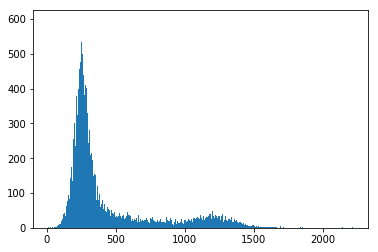

In [16]:
#histogram of the S0 values (b0 image)
x = plt.hist(S0s.ravel(), 500)

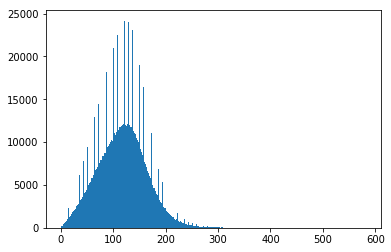

In [17]:
# Histogram of the S_k values
x = plt.hist(data[:, :, :, ~gtab.b0s_mask].ravel(), 500)

The S0 values look nicely bimodal. The S_k values look gaussian with wierd spikes. Are these from eddy currents or head motion?

In [18]:
# Plot z-indices of a 3D volume
def plot_3d_z_indices(vol, idx_list, transpose=True,
                      num_rows=1, num_cols=1, 
                      label_loc_x=5, label_loc_y=5, 
                      im_origin = "lower"):
    """Plot z-index slices of a 3d volume as subplots"""
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    fig.subplots_adjust(wspace=0.025, hspace=0.0)

    im = None
    for i, idx in enumerate(idx_list):
        plt.subplot(num_rows, num_cols, i+1)
        plt.text(label_loc_x, label_loc_y, str(idx), fontsize=18, 
                 ha="center", color="black",
                 bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        if transpose is True:
            im = plt.imshow(vol[:,:,idx].transpose(), origin=im_origin)
        else:
            im = plt.imshow(vol[:,:,idx], origin=im_origin)

    # now put a color bar on the right
    fig = plt.gcf()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax)


# Single Compartment model

In [19]:
import dipy.reconst.dti as dti
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data)

## Fractional Anisotropy

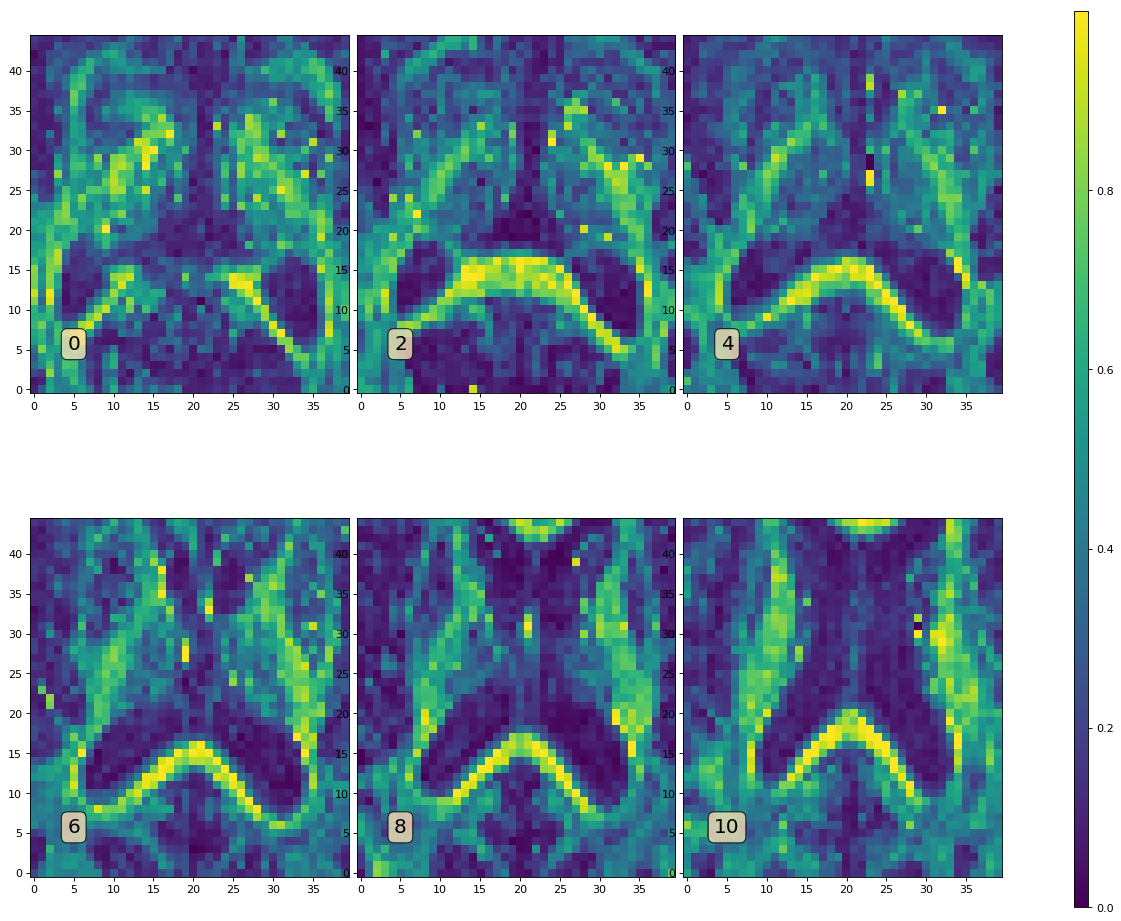

In [20]:
FA = dti.fractional_anisotropy(tenfit.evals)
plot_3d_z_indices(FA, range(0,12, 2), transpose=True, num_rows=2, num_cols=3)

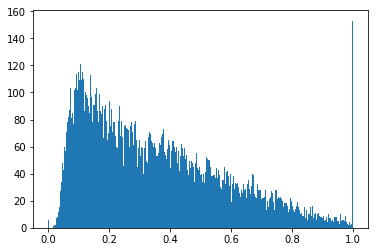

In [21]:
x = plt.hist(FA.ravel(), bins=500)

# Mean Diffusivity

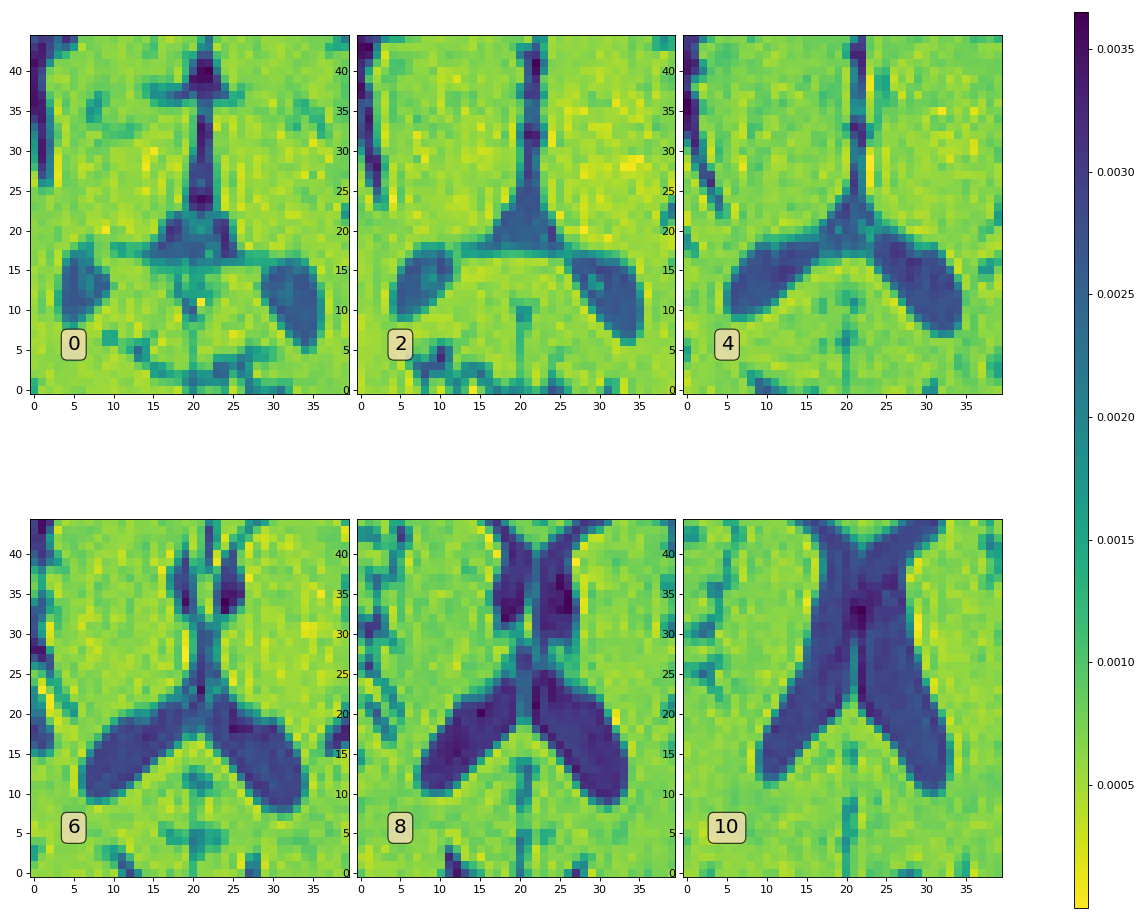

In [22]:
MD1 = dti.mean_diffusivity(tenfit.evals)
plt.set_cmap("viridis_r")
# Plot the MD for a few z-indices
plot_3d_z_indices(MD1, range(0,12, 2), transpose=True, num_rows=2, num_cols=3)

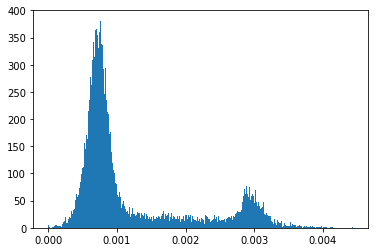

In [23]:
x = plt.hist(MD1.ravel(), bins=500)

# Bi-tensor Model (Free Water)

In [24]:
ADC_water = 3 * 1e-3
b_value = gtab.bvals[1]
Awater_scalar = np.exp(- b_value * ADC_water)
print("Awater_k = %.2f" % Awater_scalar)

Awater_k = 0.05


In [25]:
data_bi = data.astype(np.float_, copy=True)
S0s_bi = data_bi[:,:,:,gtab.b0s_mask]

Make sure there are no zeros in our signal and everything is positive

In [26]:
print("Min = %f, Max=%f" % (data_bi.min(), data_bi.max()))

Min = 0.000000, Max=2216.000000


In [27]:
data_bi[data_bi <= 0] = dti.MIN_POSITIVE_SIGNAL

In [28]:
print("Min = %f, Max=%f" % (data_bi.min(), data_bi.max()))

Min = 0.000100, Max=2216.000000


In [29]:
# Attenuations
Ahat = data_bi.copy() # attenuations
Ahat = Ahat / S0s_bi  

In [30]:
max_diffusivity = 5e-3
attenuation_min = np.exp(- b_value * max_diffusivity )

min_diffusivity = 0.01 * 1e-3
attenuation_max = np.exp(-b_value * min_diffusivity)

print("Attenuation_min = %.3f, Attenuation_max = %.3f" % 
      (attenuation_min, attenuation_max))

Attenuation_min = 0.007, Attenuation_max = 0.990


In [31]:
#Clip the attenuations to attenuation_min and attenuation_max
mask = Ahat < attenuation_min
mask[:,:,:, gtab.b0s_mask] = False
Ahat[Ahat < attenuation_min] = attenuation_min

mask = Ahat > attenuation_max
mask[:,:,:, gtab.b0s_mask] = False
Ahat[Ahat > attenuation_max] = attenuation_max

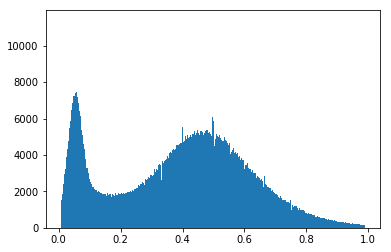

In [32]:
x = plt.hist(Ahat[:,:,:, ~gtab.b0s_mask].ravel(), bins=500)

## Initialization of Free Water Map

Fraction of Data Selected = 0.10


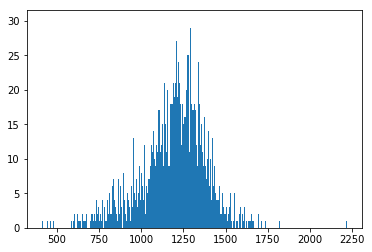

In [33]:
# look at the distribution of voxels in the b0 image that are near 3*1e-3 mm^2/s
mask = np.abs(MD1 - 3 * 1e-3) < 0.2 * 1e-3
print("Fraction of Data Selected = %.2f" % (sum(mask.ravel()) / mask.size))
x = plt.hist(S0s_bi[mask].ravel(), bins=500)

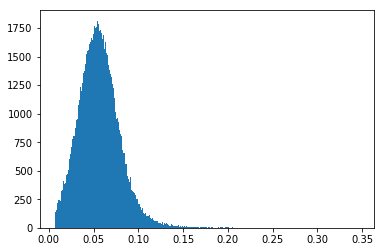

In [34]:
# Lets look at the attentuation when the FA is close to that of water
x = plt.hist(Ahat[:,:,:,1:65][mask].ravel(), bins=500)

In [35]:
#Lets set the value of Swater to be 1500 as that is close 
# to the end of the distribution in percentile terms
Swater = 1500 

Fraction of Data Selected = 0.52


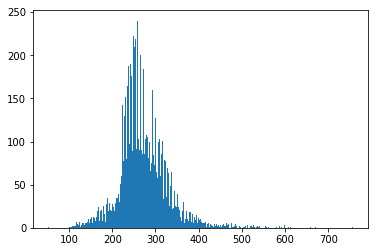

In [36]:
# look at the distribution of voxels that are near 0.8*1e-3 mm^2/s
mask = np.abs(MD1 - 0.8 * 1e-3) < 0.2 * 1e-3
print("Fraction of Data Selected = %.2f" % (sum(mask.ravel()) / mask.size))
x = plt.hist(S0s_bi[mask].ravel(), bins=500)

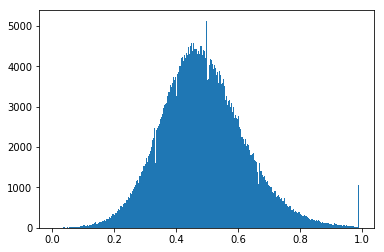

In [37]:
# Lets look at the attentuation when the FA is close to that of 
# white matter 
x = plt.hist(Ahat[:,:,:,1:65][mask].ravel(), bins=500)

In [38]:
# Lets set the value of Stissue to be 200 as that is close
# to the start of the distribution above in percentile terms
Stissue = 200

In [39]:
#Initial free water map

#looking at the distribution of mean diffusivities we can set
lambda_max = 1 * 1e-3 # max diffusivity in tissue
lambda_min = 0.3 * 1e-3 # min diffusivity in tissue

# Max and min attenuation. (Amax uses lambda_min and vice versa)
Amax = np.exp(-b_value * lambda_min)
Amin = np.exp(-b_value * lambda_max)

print("Amin=%.2f, Amax = %.2f" % (Amin, Amax))

Ahat_min = Ahat[..., ~gtab.b0s_mask].min(axis=3)
Ahat_max = Ahat[...,~gtab.b0s_mask].max(axis=3)

print("Ahat_min.shape = %s" % str(Ahat_min.shape))
print("Ahat_max.shape = %s" % str(Ahat_max.shape))

# Note this formula is perhaps a correction of Equation [6]
fmin = (Ahat_min - Awater_scalar) / (Amax - Awater_scalar)
fmax = (Ahat_max - Awater_scalar) / (Amin - Awater_scalar)

print("fmin.shape = %s" % str(fmin.shape))
print("fmax.shape = %s" % str(fmax.shape))

idx = (20, 25, 6)
print("Ahat_min=%.2f, Ahat_max=%.2f, fmax=%.2f, fmin=%.2f" % 
      (Ahat_min[idx], Ahat_max[idx], fmax[idx], fmin[idx]))

# now make sure fmax and fmin are between 0 and 1

print("fmin.max = %.2f, fmin.min=%.2f" % (fmin.max(), fmin.min()))
fmin[fmin <= 0] = 0.01
fmin[fmin >= 1] = 0.99

print("fmax.max = %.2f, fmax.min=%.2f" % (fmax.max(), fmax.min()))
fmax[fmax <= 0] = 0.01
fmax[fmax >= 1] = 0.99
print("fmax.max = %.2f, fmax.min=%.2f" % (fmax.max(), fmax.min()))

print("Ahat_min=%.2f, Ahat_max=%.2f, fmax=%.2f, fmin=%.2f" % 
      (Ahat_min[idx], Ahat_max[idx], fmax[idx], fmin[idx]))

# FIXME: setting fmin to 0 and fmax to 1
fmin[...] = 0 + 0.00001
fmax[...] = 1 - 0.00001

f_init = 1 - (np.log(np.squeeze(S0s_bi) / Stissue) / np.log(Swater / Stissue))
print("f_init.shape = %s" % str(f_init.shape))
mask = f_init < fmin
f_init[mask] = (fmin[mask] + fmax[mask])/2
mask = f_init > fmax
f_init[mask] = (fmin[mask] + fmax[mask])/2

f_init = f_init[:,:,:,np.newaxis]

# This is our starting value of f
print("f_init.shape = %s" % str(f_init.shape))
print("f_init.max = %.2f, f_init.min=%.2f" % (f_init.max(), f_init.min()))

Amin=0.37, Amax = 0.74
Ahat_min.shape = (40, 45, 12)
Ahat_max.shape = (40, 45, 12)
fmin.shape = (40, 45, 12)
fmax.shape = (40, 45, 12)
Ahat_min=0.02, Ahat_max=0.19, fmax=0.45, fmin=-0.05
fmin.max = 1.16, fmin.min=-0.06
fmax.max = 2.96, fmax.min=-0.05
fmax.max = 1.00, fmax.min=0.00
Ahat_min=0.02, Ahat_max=0.19, fmax=0.45, fmin=0.01
f_init.shape = (40, 45, 12)
f_init.shape = (40, 45, 12, 1)
f_init.max = 1.00, f_init.min=0.00


In [40]:

print("f_init.max = %.2f" % f_init.max())
print("Ahat.max = %.2f" % Ahat.max())

Cwater = (1 - f_init) * Awater_scalar
print("b_value = %.2f" % b_value)
print("Cwater.max = %.2f" % Cwater.max())
print(Cwater.shape)

Ahat_tissue = (Ahat - Cwater) / f_init
print(Ahat_tissue.shape)

#np.unravel_index(Ahat_tissue.argmax(), Ahat_tissue.shape)
#print(Ahat.max())
#print(Ahat_tissue.max())
#print(Ahat_tissue.argmin())

#idx = np.unravel_index(Ahat_tissue.argmin(), Ahat_tissue.shape)
#print(idx)


f_init.max = 1.00
Ahat.max = 0.99
b_value = 1000.00
Cwater.max = 0.05
(40, 45, 12, 1)
(40, 45, 12, 65)


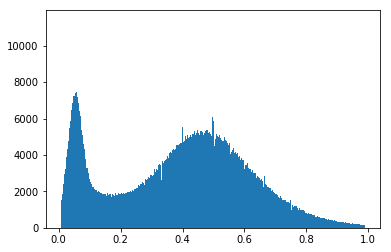

In [41]:
x = plt.hist(Ahat[:,:,:,~gtab.b0s_mask].ravel(), 500)

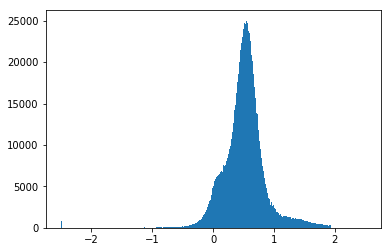

In [42]:
attenuations = Ahat_tissue[:,:,:,~gtab.b0s_mask]
np.clip(attenuations, a_min=-2.5, a_max=2.5, out=attenuations)
x = plt.hist(attenuations.ravel(), 500)

In [43]:
# This is our starting value of D
tenfit.quadratic_form.shape

(40, 45, 12, 3, 3)

In [44]:
tenfit.quadratic_form[20, 20, :, 2, 2]

array([0.00217376, 0.00251089, 0.00311029, 0.00316145, 0.00266007,
       0.00277519, 0.00263072, 0.00212369, 0.00178398, 0.00132135,
       0.00038067, 0.00058536])

In [45]:
def create_feature_spatial_manifold(S0, D):
    b0_shape = S0.shape
    d_shape = D.shape
    if (b0_shape[:3] != d_shape[:3]):
        raise ValueError("b0_shape = %s and d_shape = %s." \
                         "The first three dimensions need to match" 
                         % (b0_shape, d_shape))
    manifold_shape = d_shape[:3] + (6,)
    manifold = np.empty(manifold_shape, dtype=D.dtype)
    manifold[...,0] = D[...,0,0]
    manifold[...,1] = D[...,1,1]
    manifold[...,2] = D[...,2,2]
    manifold[...,3] = D[...,0,1] * np.sqrt(2)
    manifold[...,4] = D[...,1,2] * np.sqrt(2)
    manifold[...,5] = D[...,0,2] * np.sqrt(2)
    return(manifold)

manifold = create_feature_spatial_manifold(S0s, tenfit.quadratic_form)

In [46]:
def dx_manifold(manifold, idx):
    "Backwards difference of manifold co-ordinate idx along the x-axis"
    dx = np.empty(manifold.shape[:-1] + (1,), dtype=manifold.dtype)
    dx[1:,:, :, 0] = manifold[1:, :, :, idx] - manifold[:-1,:, :, idx]
    dx[0, :, :, 0] = 0.
    return(dx)

def dy_manifold(manifold, idx):
    "Backwards difference of manifold co-ordinate idx along the y-axis"
    dy = np.empty(manifold.shape[:-1] + (1,), dtype=manifold.dtype)
    dy[:,1:, :, 0] = manifold[:, 1:, :, idx] - manifold[:, :-1, :, idx]
    dy[:, 0, :, 0] = 0.
    return(dy)

def dz_manifold(manifold, idx):
    "Backwards difference of manifold co-ordinate idx along the z-axis"
    dz = np.empty(manifold.shape[:-1] + (1,), dtype=manifold.dtype)
    dz[:, :,1:, 0] = manifold[:,:, 1:, idx] - manifold[:, :, :-1, idx]
    dz[:, :,0, 0] = 0.
    return(dz)

In [47]:
def dpx(p):
    """Backwards derivative of the p,q,r vectors wrt x"""
    p = np.squeeze(p)
    ret = np.empty_like(p)
    ret[:-1, :, :] = p[1:, :, :] - p[:-1, :,:]
    ret[-1, :, :] = 0.
    return(ret)

def dpy(p):
    """Backwards derivative of the p,q,r vectors wrt y"""
    p = np.squeeze(p)
    ret = np.empty_like(p)
    ret[:, :-1, :] = p[:,1:, :] - p[:, :-1, :]
    ret[:, -1, :] = 0.
    return(ret)

def dpz(p):
    """Backwards derivative of the p,q,r vectors wrt z"""
    p = np.squeeze(p)
    ret = np.empty_like(p)
    ret[:,:, :-1] = p[:, :, 1:] - p[:, :, :-1]
    ret[:,:, -1] = 0.
    return(ret)

In [48]:
from abc import ABC, abstractmethod

class Tracer(ABC):
    
    """Abstract class to trace the values in the Free Water Gradient Descent"""

    def __init__(self):
        self.val_list = []
        self.val_names = ""
        self.rec = None
        
    def set_val_names(self, names):
        self.val_names = names
        
    def trace_after_increments_compute(self, fw):
        pass
    
    def trace_after_loss_functions(self, fw):
        pass
    
    def trace_after_increment(self, fw):
        pass
    
    def trace_after_constrain(self, fw):
        pass
    
    def add_to_list(self, vals):
        self.val_list.append(vals)
    
    def finalize(self, fw):
        if self.val_list:
            self.rec = np.rec.fromrecords(self.val_list, names=self.val_names)

class LossTracer(Tracer):
    """Trace the loss values"""
    
    def __init__(self):
        Tracer.__init__(self)
        self.set_val_names("fidelity,beltrami,loss")
        
    def trace_after_loss_functions(self, fw):
        total_loss_fid = np.asscalar(fw.total_loss_fid)
        total_loss_vol = np.asscalar(fw.total_loss_vol)
        loss = np.asscalar(fw.loss)
        self.add_to_list([total_loss_fid, total_loss_vol, loss])  
    
class IdxTracer(Tracer):
    """Trace values at one index"""
        
    def __init__(self, idx):
        Tracer.__init__(self)
        self.idx = idx
        self.set_val_names("loss,f,finc,x4inc,detg,x4m")
    
    def trace_after_loss_functions(self, fw):
        def extract_scalar_at_idx(arr_name):
            return(np.asscalar(getattr(fw, arr_name)[self.idx]))
        arr_names = ["loss_fid", "f", "finc", "x4inc", "detg"]
        x4m = np.asscalar(fw.manifold[...,0][idx])
        self.add_to_list([extract_scalar_at_idx(name) for name in arr_names] + [x4m])


In [49]:
class FreeWaterGradientDescent:
    
    """Class to run the Free Water Gradient Descent Computations"""
    
    UNDERFLOW_MIN = 1e-20
    
    def __init__(self, Ahat, manifold, f_init, gtab, b_value, dt, 
                 beta = 10, alpha_reg=1., alpha_fid=1., water_d = 3e-3):
        self.b_value = b_value
        self.dt = dt
        
        self.beta = beta 
        self.alpha_reg = alpha_reg
        self.alpha_fid = alpha_fid
        
        self.Awater_scalar = np.exp(-water_d * self.b_value)
        
        # these two variables are not modified at all in this class
        self.gtab = gtab
        self.Ahat = Ahat
        self.qk = self.gtab.bvecs[~self.gtab.b0s_mask]
        
        self.manifold_init = manifold
        self.f_init = f_init
        # numpy arrays that will be iteratated over
        self.manifold = self.manifold_init.copy()
        self.f = self.f_init.copy()
        
        # All the intermediate arrays should be initialized however lets not do it right now
        self.tracers = []
        
    def compute_regularization_increments(self):
        self.X4x = dx_manifold(self.manifold, 0)
        self.X4y = dy_manifold(self.manifold, 0)
        self.X4z = dz_manifold(self.manifold, 0)

        #print_trace(X4x, "X4x")

        self.X5x = dx_manifold(self.manifold, 1)
        self.X5y = dy_manifold(self.manifold, 1)
        self.X5z = dz_manifold(self.manifold, 1)

        self.X6x = dx_manifold(self.manifold, 2)
        self.X6y = dy_manifold(self.manifold, 2)
        self.X6z = dz_manifold(self.manifold, 2)

        self.X7x = dx_manifold(self.manifold, 3)
        self.X7y = dy_manifold(self.manifold, 3)
        self.X7z = dz_manifold(self.manifold, 3)

        self.X8x = dx_manifold(self.manifold, 4)
        self.X8y = dy_manifold(self.manifold, 4)
        self.X8z = dz_manifold(self.manifold, 4)

        self.X9x = dx_manifold(self.manifold, 5)
        self.X9y = dy_manifold(self.manifold, 5)
        self.X9z = dz_manifold(self.manifold, 5)
        
        self.g11 = np.ones(self.X4x.shape) + self.beta * \
            (self.X4x*self.X4x + self.X5x*self.X5x + self.X6x*self.X6x + self.X7x*self.X7x + 
                                       self.X8x*self.X8x + self.X9x*self.X9x)
        self.g22 = np.ones(self.X4y.shape) + self.beta * \
            (self.X4y*self.X4y + self.X5y*self.X5y + self.X6y*self.X6y + self.X7y*self.X7y + 
                                       self.X8y*self.X8y + self.X9y*self.X9y)
        self.g33 = np.ones(self.X4z.shape) + self.beta * \
            (self.X4z*self.X4z + self.X5z*self.X5z + self.X6z*self.X6z + self.X7z*self.X7z + 
                                       self.X8z*self.X8z + self.X9z*self.X9z)
        self.g12 = self.beta * (self.X4x*self.X4y + self.X5x*self.X5y + self.X6x*self.X6y + 
                                self.X7x*self.X7y + self.X8x*self.X8y + self.X9x*self.X9y)
        self.g23 = self.beta * (self.X4y*self.X4z + self.X5y*self.X5z + self.X6y*self.X6z + 
                                self.X7y*self.X7z + self.X8y*self.X8z + self.X9y*self.X9z)
        self.g13 = self.beta * (self.X4x*self.X4z + self.X5x*self.X5z + self.X6x*self.X6z + 
                                self.X7x*self.X7z + self.X8x*self.X8z + self.X9x*self.X9z)

        #print_trace(g11, "g11")
    
        self.C11 = self.g22*self.g33 - self.g23*self.g23
        self.C22 = self.g11*self.g33 - self.g13*self.g13
        self.C33 = self.g11*self.g22 - self.g12*self.g12
        self.C12 = -self.g12*self.g33 + self.g13*self.g23
        self.C23 = -self.g11*self.g23 + self.g13*self.g12
        self.C13 = self.g12*self.g23 - self.g13*self.g22

        #print_trace(C11, "C11")
    
        self.detg = self.g11*self.C11 + self.g12*self.C12 + self.g13*self.C13
        #print_trace(detg, "detg")

        self.gm05 = 1. / np.sqrt(self.detg)
        #print_trace(gm05, "gm05")

        self.p4 = self.C11*self.X4x + self.C12*self.X4y + self.C13*self.X4z
        self.p5 = self.C11*self.X5x + self.C12*self.X5y + self.C13*self.X5z
        self.p6 = self.C11*self.X6x + self.C12*self.X6y + self.C13*self.X6z
        self.p7 = self.C11*self.X7x + self.C12*self.X7y + self.C13*self.X7z
        self.p8 = self.C11*self.X8x + self.C12*self.X8y + self.C13*self.X8z
        self.p9 = self.C11*self.X9x + self.C12*self.X9y + self.C13*self.X9z

        self.q4 = self.C12*self.X4x + self.C22*self.X4y + self.C23*self.X4z
        self.q5 = self.C12*self.X5x + self.C22*self.X5y + self.C23*self.X5z
        self.q6 = self.C12*self.X6x + self.C22*self.X6y + self.C23*self.X6z
        self.q7 = self.C12*self.X7x + self.C22*self.X7y + self.C23*self.X7z
        self.q8 = self.C12*self.X8x + self.C22*self.X8y + self.C23*self.X8z
        self.q9 = self.C12*self.X9x + self.C22*self.X9y + self.C23*self.X9z

        self.r4 = self.C13*self.X4x + self.C23*self.X4y + self.C33*self.X4z
        self.r5 = self.C13*self.X5x + self.C23*self.X5y + self.C33*self.X5z
        self.r6 = self.C13*self.X6x + self.C23*self.X6y + self.C33*self.X6z
        self.r7 = self.C13*self.X7x + self.C23*self.X7y + self.C33*self.X7z
        self.r8 = self.C13*self.X8x + self.C23*self.X8y + self.C33*self.X8z
        self.r9 = self.C13*self.X9x + self.C23*self.X9y + self.C33*self.X9z

        # Beltrami operator incrementals
        self.b4inc = (dpx(self.p4 * self.gm05) + dpy(self.q4 * self.gm05) + dpz(self.r4 * self.gm05)) * np.squeeze(self.gm05)
        self.b5inc = (dpx(self.p5 * self.gm05) + dpy(self.q5 * self.gm05) + dpz(self.r5 * self.gm05)) * np.squeeze(self.gm05)
        self.b6inc = (dpx(self.p6 * self.gm05) + dpy(self.q6 * self.gm05) + dpz(self.r6 * self.gm05)) * np.squeeze(self.gm05)
        self.b7inc = (dpx(self.p7 * self.gm05) + dpy(self.q7 * self.gm05) + dpz(self.r7 * self.gm05)) * np.squeeze(self.gm05)
        self.b8inc = (dpx(self.p8 * self.gm05) + dpy(self.q8 * self.gm05) + dpz(self.r8 * self.gm05)) * np.squeeze(self.gm05)
        self.b9inc = (dpx(self.p9 * self.gm05) + dpy(self.q9 * self.gm05) + dpz(self.r9 * self.gm05)) * np.squeeze(self.gm05)


    def compute_fidelity_increments(self):

        self.Ahat_tissue_curr = \
            self.qk[:, 0] * self.qk[:, 0] * self.manifold[..., 0:1] + \
            self.qk[:, 1] * self.qk[:, 1] * self.manifold[..., 1:2] + \
            self.qk[:, 2] * self.qk[:, 2] * self.manifold[..., 2:3] + \
            self.qk[:, 0] * self.qk[:, 1] * self.manifold[..., 3:4] * np.sqrt(2) + \
            self.qk[:, 1] * self.qk[:, 2] * self.manifold[..., 4:5] * np.sqrt(2) + \
            self.qk[:, 0] * self.qk[:, 2] * self.manifold[..., 5:6] * np.sqrt(2)
        # prevent underflow
        np.clip(self.Ahat_tissue_curr, a_min=1e-7, a_max=None, out=self.Ahat_tissue_curr) 
        self.Ahat_tissue_curr = np.exp(-self.b_value * self.Ahat_tissue_curr)
        #print_trace(Ahat_tissue_curr, "Ahat_tissue_curr", idx)

        self.A_bi = self.Ahat_tissue_curr * self.f + (1 - self.f) * self.Awater_scalar
        #print_trace(A_bi, "A_bi", idx)

        self.fidmat = self.f * (self.Ahat[..., ~gtab.b0s_mask] - self.A_bi) * self.Ahat_tissue_curr
        #print_trace(fidmat, "fidmat", idx)

        self.fid4inc = (self.fidmat * (self.qk[:, 0] * self.qk[:, 0])).sum(axis=-1)
        self.fid5inc = (self.fidmat * (self.qk[:, 1] * self.qk[:, 1])).sum(axis=-1)
        self.fid6inc = (self.fidmat * (self.qk[:, 2] * self.qk[:, 2])).sum(axis=-1)
        self.fid7inc = (self.fidmat * (self.qk[:, 0] * self.qk[:, 1])).sum(axis=-1) * np.sqrt(2) # 2 / sqrt(2)
        self.fid8inc = (self.fidmat * (self.qk[:, 1] * self.qk[:, 2])).sum(axis=-1) * np.sqrt(2)
        self.fid9inc = (self.fidmat * (self.qk[:, 0] * self.qk[:, 2])).sum(axis=-1) * np.sqrt(2)

    def compute_f_increment(self):
        self.finc = (-self.b_value) * (
            (self.Ahat[..., ~self.gtab.b0s_mask] - self.A_bi) * (self.Ahat_tissue_curr - self.Awater_scalar)).sum(axis=-1)

    def compute_manifold_increments(self):
        #incrementals are the sum of the fidelity incrementals and the beltrami incrementals
        def compute_one_manifold_increment(fidinc, reginc):
            return(self.alpha_fid * self.b_value * fidinc + self.alpha_reg * reginc)

        self.x4inc = compute_one_manifold_increment(self.fid4inc, self.b4inc)
        self.x5inc = compute_one_manifold_increment(self.fid5inc, self.b5inc)
        self.x6inc = compute_one_manifold_increment(self.fid6inc, self.b6inc)
        self.x7inc = compute_one_manifold_increment(self.fid7inc, self.b7inc)
        self.x8inc = compute_one_manifold_increment(self.fid8inc, self.b8inc)
        self.x9inc = compute_one_manifold_increment(self.fid9inc, self.b9inc)


    def compute_fidelity_loss(self):
        self.loss_fid = np.linalg.norm(self.Ahat[..., ~self.gtab.b0s_mask] - self.A_bi, axis=-1)

    def compute_volume_loss(self):
        self.loss_vol = np.sqrt(self.detg)

    def compute_total_fidelity_loss(self):
        self.total_loss_fid = np.sum(self.loss_fid)

    def compute_total_volume_loss(self):
        self.total_loss_vol = np.sum(self.loss_vol)

    def compute_total_loss(self):
        self.loss = self.alpha_fid*self.total_loss_fid + self.alpha_reg*self.total_loss_vol

    def increment_manifold(self):
        self.manifold[...,0] -= self.dt * self.x4inc
        self.manifold[...,1] -= self.dt * self.x5inc
        self.manifold[...,2] -= self.dt * self.x6inc
        self.manifold[...,3] -= self.dt * self.x7inc
        self.manifold[...,4] -= self.dt * self.x8inc
        self.manifold[...,5] -= self.dt * self.x9inc

    def constrain_manifold(self):
        np.clip(self.manifold, a_min=self.UNDERFLOW_MIN, a_max=1., out=self.manifold)

    def increment_f(self):
        self.f[...,0] -= self.dt * self.finc
        # make sure that the f values stay constrained
        self.f = self.f.squeeze()

    def constrain_f(self):
        np.clip(self.f, a_min=fmin, a_max=fmax, out=self.f)
        self.f = self.f[...,np.newaxis]

    def iterate(self):
        # compute increments
        self.compute_regularization_increments()
        self.compute_fidelity_increments()
        self.compute_manifold_increments()
        self.compute_f_increment()
        
        self.trace_after_increments_compute()

        # loss functions
        self.compute_fidelity_loss()
        self.compute_volume_loss()
        self.compute_total_fidelity_loss()
        self.compute_total_volume_loss()
        self.compute_total_loss()

        self.trace_after_loss_functions()
        
        # increment
        self.increment_manifold()
        self.increment_f()
        
        self.trace_after_increment()

        # constrain
        self.constrain_manifold()
        self.constrain_f()
        
        self.trace_after_constrain()
        
    def init_tracers(self, tracers):
        self.tracers = tracers
        
    def trace_after_increments_compute(self):
        for tracer in self.tracers:
            tracer.trace_after_increments_compute(self)
    
    def trace_after_loss_functions(self):
        for tracer in self.tracers:
            tracer.trace_after_loss_functions(self)
    
    def trace_after_increment(self):
        for tracer in self.tracers:
            tracer.trace_after_increment(self)
    
    def trace_after_constrain(self):
        for tracer in self.tracers:
            tracer.trace_after_constrain(self)
            
    def finalize(self):
        for tracer in self.tracers:
            tracer.finalize(self)

In [50]:
manifold = create_feature_spatial_manifold(S0s, tenfit.quadratic_form)
num_gradients = np.sum(~gtab.b0s_mask)
dt = 0.1 / (b_value * num_gradients)

fw_gd = FreeWaterGradientDescent(Ahat, manifold, f_init, gtab, b_value, dt)
idx_tracer = IdxTracer((2, 21, 5, Ellipsis))
loss_tracer = LossTracer()
fw_gd.init_tracers([loss_tracer, idx_tracer])

num_iterations = 1000
for i in range(num_iterations):
    fw_gd.iterate()

fw_gd.finalize()

idx_array = idx_tracer.rec
loss_array = loss_tracer.rec

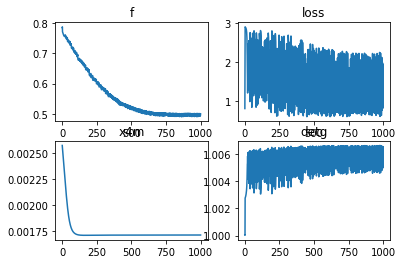

In [51]:
# Plot tissue map, loss functions for idx
fig, axes = plt.subplots(2, 2)
axes[0,0].set_title("f")
axes[0,0].plot(idx_array.f)
axes[0,1].set_title("loss")
axes[0,1].plot(idx_array.loss)
axes[1,0].set_title("x4m")
axes[1,0].plot(idx_array.x4m)
axes[1,1].set_title("detg")
axes[1,1].plot(idx_array.detg)

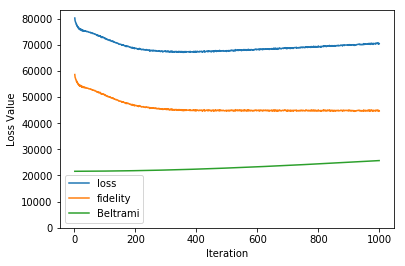

In [52]:
#loss functions
loss_array.loss[0:2] = np.NaN
plt.plot(loss_array.loss, label="loss")
loss_array.fidelity[0:2] = np.NaN
plt.plot(loss_array.fidelity, label="fidelity")
loss_array.beltrami[0:2] = np.NaN
plt.plot(loss_array.beltrami, label="Beltrami")
plt.gca().set_ylim(ymin=0)
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.legend()

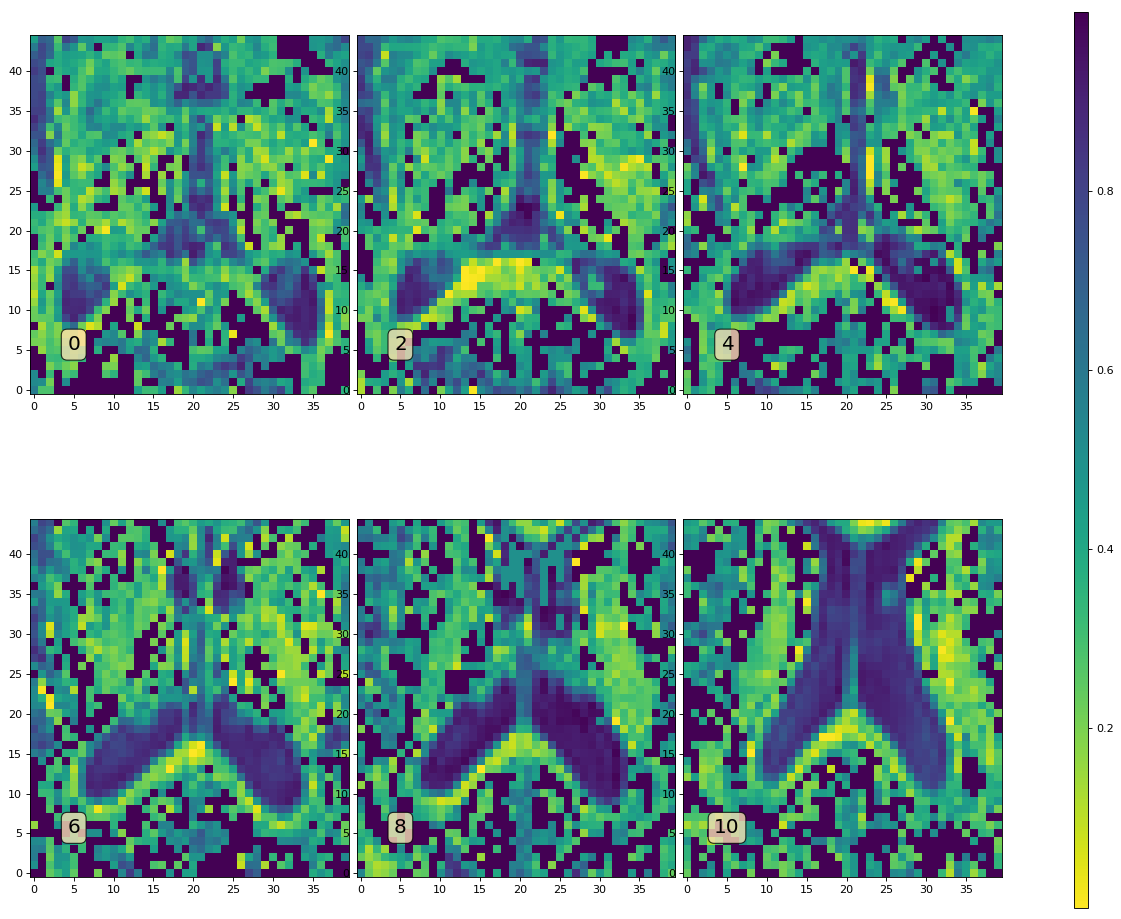

In [53]:
# free water map after iterations
plt.set_cmap("viridis_r")
plot_3d_z_indices(1 - fw_gd.f.squeeze(), range(0,12, 2), transpose=True, num_rows=2, num_cols=3)

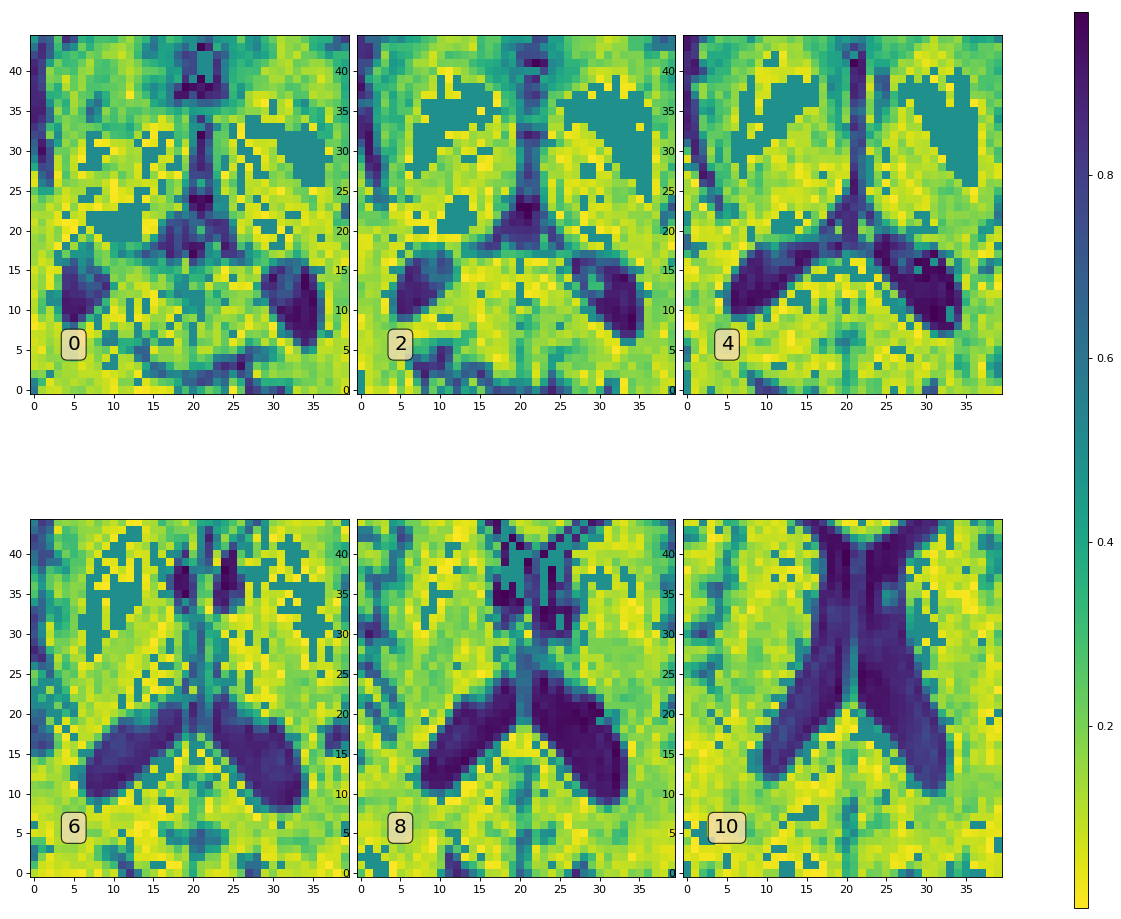

In [54]:
# initial Free water map
plt.set_cmap("viridis_r")
plot_3d_z_indices(1 - fw_gd.f_init.squeeze(), range(0,12, 2), transpose=True, num_rows=2, num_cols=3)

In [56]:
# save free water output to file
fw_file = base_filename + ".fw.nii.gz"
nib.save(nib.Nifti1Image((1 - fw_gd.f).squeeze(), img.affine), fw_file)